In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy import interpolate
import networkx as nx

import pandas as pd
from sklearn.cluster import KMeans

from sknetwork.hierarchy import cut_straight, Paris
from sknetwork.visualization import svg_dendrogram, svg_graph

import landscape as ld
from networkx.algorithms import approximation as apx

from IPython.display import SVG

from typing import List, Tuple

In [3]:
Point = Tuple[int, int]

# utils

## terminals/points

In [4]:
def set_terminals_in_graph(G: nx.Graph, points: List[Point]) -> None:
    set_points(G, points)

In [5]:
def set_points(G: nx.Graph, points: List[Point]) -> None:
    """
    Set terminals/points to a graph G
    
    If a node is terminal, its attribute `type` is set to `terminal`. 
    """
    G = G.copy()
    terminal_nodes_list = {node: "terminal" if node in points else None for node in G.nodes()}
    nx.set_node_attributes(G, terminal_nodes_list, "type")
    
    return G

In [6]:
def get_points(G: nx.graph) -> List[Point]:
    """Get terminal nodes from graph ``G``."""
    points = [k for k,v in nx.get_node_attributes(G, "type").items() 
              if v == "terminal"]
    return points

In [7]:
def convert_points_array_to_list(points_array):
    return [(e[0], e[1]) for e in points_array]

In [8]:
def get_Lx_Ly(G: nx.Graph, L: int=None) -> [int, int]:
    # compute L wrt node coords
    if L is None:
        Lx, Ly = np.array([node for node in G.nodes()]).max(axis=0) + [1, 1]
    else:
        Lx = Ly = L
    
    return Lx, Ly

## graphs

In [9]:
def get_pos(g: nx.Graph) -> dict:
    return dict( (n, n) for n in g.nodes() )

In [10]:
def create_graph(L: int, points: List[Point]=None) -> nx.Graph:
    """
    Create a graph based on a squared 2D-grid of L*L nodes.
    
    Args:    
        L (int): size of the box. The number of nodes in the graph will be L*L
        points (List[Point]): list of points where important nodes are
    
    Returns:
        nx.Graph: networkx graph
    
    """    
    # create square grid graph
    G = nx.grid_2d_graph(range(1,int(L)), range(1,int(L)))
    
    if points is not None:
        G = set_points(G, points)
    
    return G

## algos

In [11]:
def remove_edges_landscape_method(G: nx.Graph, Nx0: int, alpha: float, A0: int=5000):
    """
    Remove edges of graph ``G`` by using a landscape function.
    
    Args:
        G (nx.Graph): networkx graph
        Nx0 (int): number of  grid points
        alpha (float): threshold parameter to remove edges. Delete edges 
            where the landscape function > alpha 
        A0 (int): A0 parameter to be used by the landscape function.
    """
    G = G.copy()
    
    points = get_points(G)
    Lx, Ly = get_Lx_Ly(G)
    if Lx != Ly:
        raise NotImplementedError("Only implemented for squared grids")
    L = Lx
    
    #compute landscape function
    fLand = ld.find_landscape(Nx0 = Nx0, L = L, A0 = 5000, points = points)

    print( 'number of original edges {}'.format(len(G.edges))) 
    
    # delete edges where the landscape function > alpha 
    for e in G.edges:
        x, y = 0.5*(np.array(e[0]) + np.array(e[1]))
        if fLand(x,y) > alpha:
            G.remove_edge(e[0],e[1])
            
    # delete nodes with degree 1
    ends = [ x[0] for x in G.degree() if x[1] <= 1]
    G.remove_nodes_from(ends)
            
    print( 'number of final edges {}'.format(len(G.edges)))
            
    return G

In [12]:
def get_naive_steiner(G: nx.Graph, points: List[Point]=None) -> nx.Graph:
    """
    Returns a Steiner Tree for a graph ``G`` withe terminals ``points``
    
    Note: The algorithm is an approximation of the optimal weighted 
        Steiner Tree problem.
    """
    if points is None:
        points = get_points(G)
    # approximate steiner tree
    G_st = apx.steinertree.steiner_tree(G, points, weight='length') 
    print('The number of edges of the Steiner tree is '+ str(G_st.number_of_edges()))
    return G_st

In [13]:
def get_steiner_per_component(G: nx.Graph, points: List[Point]=None):

    def _add_symmetric_edges(edges_set):
        return edges_set.union(set([(e[1], e[0]) for e in edges_set]))
    
    G = G.copy()
    if points is None:
        points = get_points(G)
    
    # all connected components of G after cutting edges
    graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        
    # compute steiner for smaller G
    count_edges = 0
    ld_st_edges_set = set()
    for graph in graphs:
        points_in_subgraph = [p for p in graph.nodes() if p in points]
        G_st = apx.steinertree.steiner_tree(graph, points_in_subgraph, weight='length') 
        count_edges += G_st.number_of_edges()
        ld_st_edges_set = ld_st_edges_set.union(set(list(G_st.edges())))
            
    print('The total number of edges of the Steiner trees is '+ str(count_edges))
    
    G.remove_edges_from(list(set(list(G.edges())) - _add_symmetric_edges(ld_st_edges_set)))
    
    return G

## plots

In [14]:
def plot_graph(G: nx.Graph, L: int=None, tree=None):
    """
    Plot graph with terminal nodes.
    
    Terminals correspond the nodes with attribute `type` equals to `terminal`
    """
    
    Lx, Ly = get_Lx_Ly(G, L)
    
    # plotology 
    fig, ax = plt.subplots(figsize=(6,6));

    node_pos = dict( (n, n) for n in G.nodes() )

    terminals_list = [k for k,v in nx.get_node_attributes(G, "type").items() 
                      if v == "terminal"]
    xpoints, ypoints = np.array(terminals_list).T
    
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)

    nx.draw_networkx_edges(G, node_pos, ax=ax, with_labels=False)

    # add tree
    if tree is not None:
        nx.draw(tree, node_pos, ax=ax, node_size=0, edge_color='r', width=2.5)

    # add scatter plot
    plt.scatter(xpoints, ypoints)
    
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.axis('on')
    plt.show()

# Hierarchy

Based on [the scikit network example](https://scikit-network.readthedocs.io/en/latest/tutorials/hierarchy/paris.html#Graphs)

## points

In [15]:
# points we want to cluster and join
points = [(1, 1), (2, 2), (3, 4), (5, 1), (5, 4), (8, 2), (7, 8), (6,  6), (2,8), (4,3) ]
#points = [[1, 1], [2, 2], [3, 4], [5, 1], [5, 4], [8, 2], [7, 8], [6,  6] , [2, 8], [4,3] ]

In [16]:
G = create_graph(L = 10, points = points)

In [17]:
G_st = get_naive_steiner(G)

The number of edges of the Steiner tree is 26


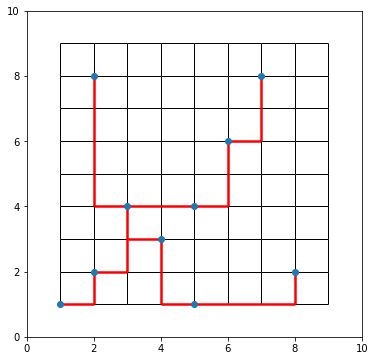

In [18]:
plot_graph(G, tree=G_st)

## Hierarchy

In [19]:
adjacency = nx.adjacency_matrix(G_st)

In [20]:
paris = Paris()

In [21]:
dendrogram = paris.fit_transform(adjacency)

## main dendrogram

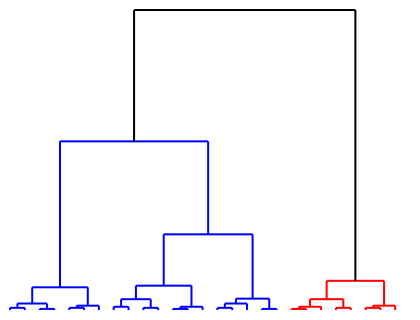

In [22]:
SVG(svg_dendrogram(dendrogram))

## dendrogram with a specific threshold/clusters

In [23]:
labels, dendrogram_aggregate = cut_straight(dendrogram, 
                                            #n_clusters=5, 
                                            threshold=0.2,
                                            return_dendrogram=True
                                           )
print(labels)

[2 2 7 5 3 0 4 0 4 1 6 6 2 5 3 2 0 1 4 0 7 5 6 3 1 0 1]


In [24]:
_, counts = np.unique(labels, return_counts=True)

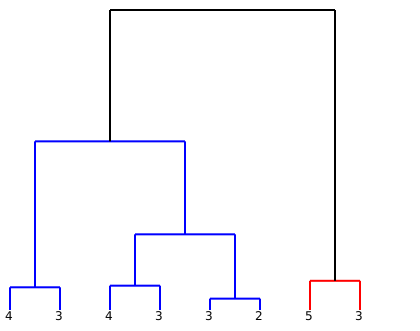

In [25]:
SVG(svg_dendrogram(dendrogram_aggregate, 
                   names=counts, 
                   rotate_names=False
                  )
)

## plot graph with clusters

In [26]:
position = np.array(G_st.nodes())

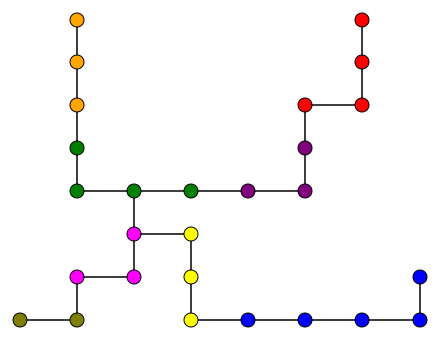

In [27]:
SVG(svg_graph(adjacency, position, labels=labels))

# quotient graph

In [53]:
node_label = dict(zip(G_st.nodes(), labels))

In [56]:
same_component = lambda u, v: node_label[u] == node_label[v]

In [58]:
G_q = nx.quotient_graph(G_st, same_component)

In [61]:
G_q.nodes()

NodeView((frozenset({(2, 6), (2, 7), (2, 8)}), frozenset({(1, 1), (2, 1)}), frozenset({(7, 1), (8, 1), (6, 1), (5, 1), (8, 2)}), frozenset({(5, 4), (6, 4), (6, 5)}), frozenset({(6, 6), (7, 6), (7, 7), (7, 8)}), frozenset({(4, 1), (4, 2), (4, 3)}), frozenset({(3, 2), (3, 3), (2, 2)}), frozenset({(4, 4), (2, 4), (2, 5), (3, 4)})))

In [62]:
G_q.edges()

EdgeView([(frozenset({(2, 6), (2, 7), (2, 8)}), frozenset({(4, 4), (2, 4), (2, 5), (3, 4)})), (frozenset({(1, 1), (2, 1)}), frozenset({(3, 2), (3, 3), (2, 2)})), (frozenset({(7, 1), (8, 1), (6, 1), (5, 1), (8, 2)}), frozenset({(4, 1), (4, 2), (4, 3)})), (frozenset({(5, 4), (6, 4), (6, 5)}), frozenset({(6, 6), (7, 6), (7, 7), (7, 8)})), (frozenset({(5, 4), (6, 4), (6, 5)}), frozenset({(4, 4), (2, 4), (2, 5), (3, 4)})), (frozenset({(4, 1), (4, 2), (4, 3)}), frozenset({(3, 2), (3, 3), (2, 2)})), (frozenset({(3, 2), (3, 3), (2, 2)}), frozenset({(4, 4), (2, 4), (2, 5), (3, 4)}))])

## quotien graph with new node labels

In [64]:
G_relabel = nx.quotient_graph(G_st, same_component, relabel=True)

In [65]:
G_relabel.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7))

In [66]:
G_relabel.edges()

EdgeView([(0, 7), (1, 6), (2, 5), (3, 4), (3, 7), (5, 6), (6, 7)])

In [107]:
def centroid(node_set):
    # TODO: refactor
    x_values, y_values = zip(*list(node_set))
    return (np.mean(x_values), np.mean(y_values))

In [111]:
node_pos = {n: centroid(n) for n in G_q.nodes()}

In [119]:
node_color = {n: node_label[list(n)[0]] for n in G_q.nodes()}

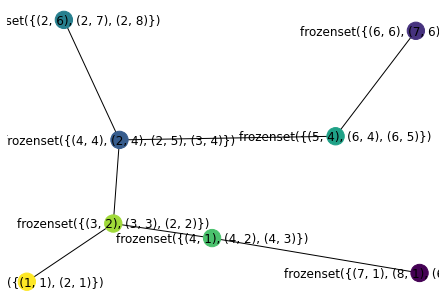

In [127]:
nx.draw(G_q, 
        pos=node_pos, 
        with_labels=True,
        node_color=list(node_color.values()),
       )